In [1]:
from Common import DiGraph
import numpy as np
import pandas as pd
import copy
from TopoSortUtils import TopoOrder
from functools import reduce
import random
import time
import sys, os
from DVEsetUtils import DVEset

import networkx as nx
import bnlearn as bn
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from pgmpy.models import BayesianModel,BayesianNetwork
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination

from sklearn.metrics import mean_squared_error 


# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))



In [2]:
R = ['MakeModel','Antilock','ILiCost','Mileage']
G = {'Age':['GoodStudent','SocioEcon', 'RiskAversion', 'DrivingSkill', 'SeniorTrain', 'MedCost'],'SocioEcon':['GoodStudent', 'RiskAversion', 'VehicleYear', 'MakeModel', 'HomeBase', 'AntiTheft', 'OtherCar'],
     'RiskAversion':['VehicleYear', 'MakeModel', 'DrivQuality', 'SeniorTrain', 'HomeBase', 'AntiTheft', 'DrivHist'],'VehicleYear':['RuggedAuto', 'Antilock', 'CarValue', 'Airbag'],'ThisCarDam':['ThisCarCost'],
     'RuggedAuto':['ThisCarDam', 'OtherCarCost', 'Cushioning'],'Accident':['ThisCarDam', 'OtherCarCost', 'MedCost', 'ILiCost'],'MakeModel':['RuggedAuto', 'Antilock', 'CarValue', 'Airbag'],
     'DrivQuality':['Accident'],'Mileage':['Accident', 'CarValue'],'Antilock':['Accident'],'DrivingSkill':['DrivQuality', 'DrivHist'],'SeniorTrain':['DrivingSkill'],'ThisCarCost':['PropCost'],'Theft':['ThisCarCost'],'CarValue':['ThisCarCost', 'Theft']
    ,'HomeBase':['Theft'],'AntiTheft':['Theft'],'OtherCarCost':['PropCost'],'Cushioning':['MedCost'],'Airbag':['Cushioning'],'GoodStudent':[],'OtherCar':[],'DrivHist':[],'MedCost':[],'ILiCost':[],'PropCost':[]}
An_R = DiGraph(G).ancestors(R)
An_R = DiGraph(G).inducedSubgraph(An_R)

In [3]:
An_R

{'Age': ['SocioEcon', 'RiskAversion', 'DrivingSkill', 'SeniorTrain'],
 'SocioEcon': ['RiskAversion', 'MakeModel', 'VehicleYear'],
 'RiskAversion': ['SeniorTrain', 'MakeModel', 'VehicleYear', 'DrivQuality'],
 'VehicleYear': ['Antilock'],
 'Accident': ['ILiCost'],
 'MakeModel': ['Antilock'],
 'DrivQuality': ['Accident'],
 'Mileage': ['Accident'],
 'Antilock': ['Accident'],
 'DrivingSkill': ['DrivQuality'],
 'SeniorTrain': ['DrivingSkill'],
 'ILiCost': []}

In [4]:
M = ['Age','SocioEcon','RiskAversion','Accident','DrivingSkill','SeniorTrain','DrivQuality','VehicleYear']

In [5]:
dve = DVEset(An_R)
G_sat, G_dve, add_edges = dve.get_set_min_graph(M)

In [6]:
G_dve._graph_dict

{'MakeModel': ['Antilock', 'ILiCost'],
 'Mileage': ['ILiCost'],
 'Antilock': ['ILiCost'],
 'ILiCost': []}

In [7]:
model_V = BayesianModel([('Age', 'GoodStudent'), ('Age', 'SocioEcon'), ('Age', 'RiskAversion'), ('Age', 'DrivingSkill'), 
                         ('Age', 'SeniorTrain'), ('Age', 'MedCost'), ('SocioEcon', 'GoodStudent'), ('SocioEcon', 'RiskAversion'), 
                         ('SocioEcon', 'VehicleYear'), ('SocioEcon', 'MakeModel'), ('SocioEcon', 'HomeBase'), ('SocioEcon', 'AntiTheft'), 
                         ('SocioEcon', 'OtherCar'), ('RiskAversion', 'VehicleYear'), ('RiskAversion', 'MakeModel'), ('RiskAversion', 'DrivQuality'), 
                         ('RiskAversion', 'SeniorTrain'), ('RiskAversion', 'HomeBase'), ('RiskAversion', 'AntiTheft'), ('RiskAversion', 'DrivHist'), 
                         ('VehicleYear', 'RuggedAuto'), ('VehicleYear', 'Antilock'), ('VehicleYear', 'CarValue'), ('VehicleYear', 'Airbag'), 
                         ('ThisCarDam', 'ThisCarCost'), ('RuggedAuto', 'ThisCarDam'), ('RuggedAuto', 'OtherCarCost'), ('RuggedAuto', 'Cushioning'), 
                         ('Accident', 'ThisCarDam'), ('Accident', 'OtherCarCost'), ('Accident', 'MedCost'), ('Accident', 'ILiCost'), ('MakeModel', 'RuggedAuto'), 
                         ('MakeModel', 'Antilock'), ('MakeModel', 'CarValue'), ('MakeModel', 'Airbag'), ('DrivQuality', 'Accident'), ('Mileage', 'Accident'), 
                         ('Mileage', 'CarValue'), ('Antilock', 'Accident'), ('DrivingSkill', 'DrivQuality'), ('DrivingSkill', 'DrivHist'), 
                         ('SeniorTrain', 'DrivingSkill'), ('ThisCarCost', 'PropCost'), ('Theft', 'ThisCarCost'), ('CarValue', 'ThisCarCost'), ('CarValue', 'Theft'),
                         ('HomeBase', 'Theft'), ('AntiTheft', 'Theft'), ('OtherCarCost', 'PropCost'), ('Cushioning', 'MedCost'), ('Airbag', 'Cushioning')])

model_T = BayesianModel([('MakeModel','Antilock'),('Mileage','ILiCost'),('Antilock','ILiCost'),('MakeModel','ILiCost')])

In [8]:
model = BayesianNetwork.load('insurance.bif', filetype='bif')

In [9]:
#df = BayesianModelSampling(model).forward_sample(int(1e4))
filepath = 'insurance.bif'
model_Sample = bn.import_DAG(filepath)

[bnlearn] >Import <insurance.bif>
[bnlearn] >Loading bif file <insurance.bif>
[bnlearn] >Checking CPDs..
[bnlearn] >Warning: CPD [Accident] does not add up to 1 but is: [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
[bnlearn] >Warning: CPD [CarValue] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn] >Warning: CPD [DrivHist] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >Warning: CPD [DrivingSkill] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >Warning: CPD [HomeBase] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >Warning: CPD [MedCost] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1

In [10]:
def query_report(infer, variables, evidence=None, elimination_order="MinFill", show_progress=False, desc=""):
    if desc:
        print(desc)
    start_time = time.time()
    query_a = infer.query(variables=variables,
                      evidence=evidence,
                      elimination_order=elimination_order,
                      show_progress=show_progress)
    #print(query_a)
    #print(f'--- Query executed in {time.time() - start_time:0,.4f} seconds ---\n')
    return query_a

def get_ordering(infer, variables, evidence=None, elimination_order="MinFill", show_progress=False, desc=""):
    start_time = time.time()
    ordering = infer._get_elimination_order(variables=variables,
                                        evidence=evidence,
                                        elimination_order=elimination_order,
                                        show_progress=show_progress)
    return ordering

In [11]:
var = ['Mileage','MakeModel','Antilock','ILiCost']
heuristic = "MinNeighbors"

In [12]:
infer = VariableElimination(model)
ordering = get_ordering(infer, variables=var, elimination_order=heuristic)
a = query_report(infer, variables=var, elimination_order=ordering)

In [13]:
Sample_size_increase = pd.DataFrame()
for i in range(0,50):
    m = 500*(i+1)
    df = bn.sampling(model_Sample, n=m)
    model_V.cpds = []
    model_V.fit(data=df,
          estimator=BayesianEstimator,
          prior_type="BDeu",
          equivalent_sample_size=10,
          complete_samples_only=False)
    model_T.cpds = []
    model_T.fit(data=df,
          estimator=BayesianEstimator,
          prior_type="BDeu",
          equivalent_sample_size=10,
          complete_samples_only=False)
    
    infer_V = VariableElimination(model_V)
    infer_T = VariableElimination(model_T)
    
    ordering = get_ordering(infer_V, variables=var, elimination_order=heuristic)
    b = query_report(infer_V, variables=var, elimination_order=ordering)
       
    ordering = get_ordering(infer_T, variables=var, elimination_order=heuristic)
    c = query_report(infer_T, variables=var, elimination_order=ordering)
    
    Sample_size_increase.loc[i,'index'] = m
    
    #a.values[1,1,1,1,1] = 0.008096
    Sample_size_increase.loc[i,'Original value'] = 0.145927
    Sample_size_increase.loc[i,'Full model'] = max(b.values[1,1,1,0],b.values[1,1,0,1],b.values[1,0,1,1],b.values[0,1,1,1])
    Sample_size_increase.loc[i,'Marginal model'] = max(c.values[1,1,1,0],c.values[1,1,0,1],c.values[1,0,1,1],c.values[0,1,1,1])

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 1000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 1500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 2000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 2500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 3000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 3500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 4000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 4500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 5000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 5500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 6000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 6500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 7000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 7500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 8000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 8500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 9000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 9500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 10000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 10500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 11000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 11500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 12000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 12500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 13000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 13500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 14000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 14500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 15000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 15500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 16000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 16500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 17000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 17500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 18000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 18500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 19000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 19500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 20000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 20500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 21000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 21500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 22000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 22500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 23000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 23500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 24000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 24500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 25000 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

In [14]:
a.values[1,0,1,1]

0.000497065218940371

In [15]:
Sample_size_increase

,index,Original value,Full model,Marginal model
0,500.0,0.145927,0.134694,0.135902
1,1000.0,0.145927,0.151546,0.152002
2,1500.0,0.145927,0.147192,0.145345
3,2000.0,0.145927,0.153825,0.154684
4,2500.0,0.145927,0.143795,0.144735
5,3000.0,0.145927,0.154257,0.156666
6,3500.0,0.145927,0.143438,0.143690
7,4000.0,0.145927,0.144984,0.145626
8,4500.0,0.145927,0.148442,0.148417
9,5000.0,0.145927,0.142568,0.142985


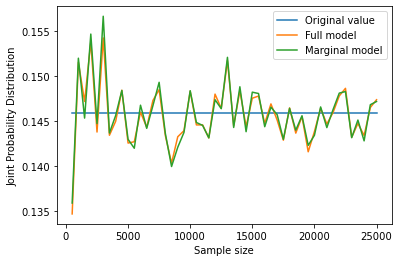

In [16]:
ax = Sample_size_increase.plot(x='index', y='Original value')
Sample_size_increase.plot(x='index', y='Full model',ax=ax)
Sample_size_increase.plot(x='index', y='Marginal model',ax=ax)
#final.plot(x='index', y='False t-elimination', legend='FT', ax=ax)
plt.xlabel("Sample size")
plt.ylabel("Joint Probability Distribution")
plt.savefig('1.png', dpi=500)

In [17]:
Sample_size_increase.to_excel('Sample_size_increase.xlsx')

In [18]:
print(mean_squared_error(Sample_size_increase['Original value'],Sample_size_increase['Full model']),mean_squared_error(Sample_size_increase['Original value'],Sample_size_increase['Marginal model']))

1.0672777112336873e-05 1.1882015535283081e-05


In [36]:
MSE = pd.DataFrame()
for k in range(0,50):
    Sample_size_increase = pd.DataFrame()
    for i in range(0,20):
        m = 500
        df = bn.sampling(model_Sample, n=m)
        model_V.cpds = []
        model_V.fit(data=df,
              estimator=BayesianEstimator,
              prior_type="BDeu",
              equivalent_sample_size=10,
              complete_samples_only=False)
        model_T.cpds = []
        model_T.fit(data=df,
              estimator=BayesianEstimator,
              prior_type="BDeu",
              equivalent_sample_size=10,
              complete_samples_only=False)
    
        infer_V = VariableElimination(model_V)
        infer_T = VariableElimination(model_T)
    
        ordering = get_ordering(infer_V, variables=var, elimination_order=heuristic)
        b = query_report(infer_V, variables=var, elimination_order=ordering)
       
        ordering = get_ordering(infer_T, variables=var, elimination_order=heuristic)
        c = query_report(infer_T, variables=var, elimination_order=ordering)
    
        Sample_size_increase.loc[i,'index'] = m
    
        #a.values[1,1,1,1,1] = 0.008096
        Sample_size_increase.loc[i,'Original value'] = 0.145927
        Sample_size_increase.loc[i,'Full model'] = max(b.values[1,1,1,0],b.values[1,1,0,1],b.values[1,0,1,1],b.values[0,1,1,1])
        Sample_size_increase.loc[i,'Marginal model'] = max(c.values[1,1,1,0],c.values[1,1,0,1],c.values[1,0,1,1],c.values[0,1,1,1])
    MSE.loc[k,'index'] = k+1
    MSE.loc[k,'MSE_Full'] = mean_squared_error(Sample_size_increase['Original value'],Sample_size_increase['Full model'])
    MSE.loc[k,'MSE_Marginal'] = mean_squared_error(Sample_size_increase['Original value'],Sample_size_increase['Marginal model'])

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
MSE = pd.read_excel('MSE.xlsx')
MSE

,Unnamed: 0,index,MSE_Full,MSE_Marginal
0,0,1,0.000098,0.000081
1,1,2,0.000275,0.000299
2,2,3,0.000111,0.000123
3,3,4,0.000162,0.000137
4,4,5,0.000093,0.000105
5,5,6,0.000157,0.000144
6,6,7,0.000109,0.000107
7,7,8,0.000184,0.000176
8,8,9,0.000092,0.000077
9,9,10,0.000158,0.000118


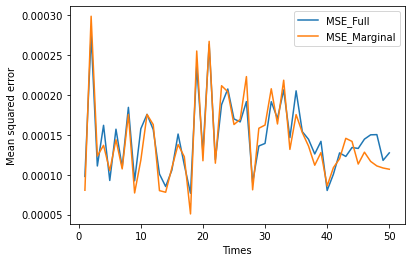

In [38]:
ax = MSE.plot(x='index', y='MSE_Full')
MSE.plot(x='index', y='MSE_Marginal',ax=ax)
#final.plot(x='index', y='False t-elimination', legend='FT', ax=ax)
plt.xlabel("Times")
plt.ylabel("Mean squared error")
plt.savefig('MSE(Sample size = 500).png', dpi=500)

In [46]:
MSE_1000 = pd.DataFrame()
for k in range(0,50):
    Sample_size_increase = pd.DataFrame()
    for i in range(0,20):
        m = 500
        df = bn.sampling(model_Sample, n=m)
        model_V.cpds = []
        model_V.fit(data=df,
              estimator=BayesianEstimator,
              prior_type="BDeu",
              equivalent_sample_size=10,
              complete_samples_only=False)
        model_T.cpds = []
        model_T.fit(data=df,
              estimator=BayesianEstimator,
              prior_type="BDeu",
              equivalent_sample_size=10,
              complete_samples_only=False)
    
        infer_V = VariableElimination(model_V)
        infer_T = VariableElimination(model_T)
        
    
        ordering = get_ordering(infer_V, variables=var, elimination_order=heuristic)
        b = query_report(infer_V, variables=var, elimination_order=ordering)
       
        ordering = get_ordering(infer_T, variables=var, elimination_order=heuristic)
        c = query_report(infer_T, variables=var, elimination_order=ordering)
    
        Sample_size_increase.loc[i,'index'] = m
    
        #a.values[1,1,1,1,1] = 0.008096
        Sample_size_increase.loc[i,'Original value'] = 0.145927
        Sample_size_increase.loc[i,'Full model'] = max(b.values[1,1,1,0],b.values[1,1,0,1],b.values[1,0,1,1],b.values[0,1,1,1])
        Sample_size_increase.loc[i,'Marginal model'] = max(c.values[1,1,1,0],c.values[1,1,0,1],c.values[1,0,1,1],c.values[0,1,1,1])
    MSE_1000.loc[k,'Index'] = k+1
    MSE_1000.loc[k,'MSE (Full model)'] = mean_squared_error(Sample_size_increase['Original value'],Sample_size_increase['Full model'])*100000
    MSE_1000.loc[k,'MSE (Marginal model)'] = mean_squared_error(Sample_size_increase['Original value'],Sample_size_increase['Marginal model'])*100000

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

[bnlearn] >Forward sampling for 500 samples..


  0%|          | 0/27 [00:00<?, ?it/s]

In [47]:
Sample_size_increase

,index,Original value,Full model,Marginal model
0,500.0,0.145927,0.143869,0.146979
1,500.0,0.145927,0.147195,0.150977
2,500.0,0.145927,0.134471,0.137973
3,500.0,0.145927,0.143010,0.144044
4,500.0,0.145927,0.143600,0.143775
5,500.0,0.145927,0.122698,0.125081
6,500.0,0.145927,0.131581,0.130476
7,500.0,0.145927,0.157106,0.158463
8,500.0,0.145927,0.125584,0.126322
9,500.0,0.145927,0.131718,0.135067


In [53]:
#MSE_1000.to_excel('MSE_500.xlsx')
MSE_1000 = pd.read_excel('MSE_1000.xlsx')
MSE_1000

,Index,MSE (Full model),MSE (Marginal model)
0,0,6.798697,6.317233
1,1,6.644001,7.173091
2,2,7.228825,6.290229
3,3,8.234687,7.225822
4,4,7.992151,8.020842
5,5,5.539625,6.034924
6,6,15.124809,15.783155
7,7,8.967651,11.525628
8,8,6.818117,8.116466
9,9,4.921815,5.268615


In [32]:
MSE_1000.columns

Index(['Index', 'MSE_Full', 'MSE_Marginal'], dtype='object')

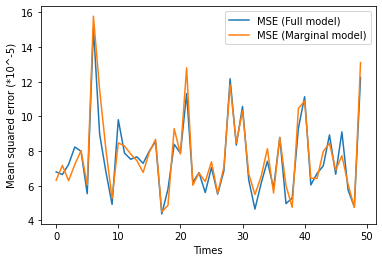

In [55]:
ax = MSE_1000.plot(x='Index', y='MSE (Full model)')
MSE_1000.plot(x='Index', y='MSE (Marginal model)',ax=ax)
#final.plot(x='index', y='False t-elimination', legend='FT', ax=ax)
plt.xlabel("Times")
plt.ylabel("Mean squared error (*10^-5)")
plt.savefig('MSE(Sample size = 1000).png', dpi=500)